In [1]:
import pymeteo
from pymeteo.data import acars
import tempfile
import netCDF4
from pymeteo import dynamics, thermo
from pymeteo.data.acars import getAirportByCode
import numpy as np
from datetime import datetime

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pymeteo
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import act
import cartopy
import cartopy.mpl.geoaxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from metpy import plots

from pymeteo.data import acars
import netCDF4
import tempfile
import time
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from datetime import datetime
import metpy.calc as mpcalc
#from metpy.io import get_upper_air_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
#from tabulate import tabulate
import numpy as np
from PIL import Image
import matplotlib.patches as patches
from matplotlib.axis import Axis
from matplotlib.patches import ConnectionPatch

In [4]:
def processDataSet(data):
    print("[+] Writing data into temporary file")
    tdata = tempfile.NamedTemporaryFile(delete=False)
    tdata.write(data.read())
    print("[-] Data written to {0}".format(tdata.name))
    print("[+] Opening data as NetCDF")
    d = data.read()
    with netCDF4.Dataset(tdata.name, mode='r') as nc:
        print("[-] Dataset open with")

        _z = nc["altitude"][:]
        _T = nc["temperature"][:]
        _qv = nc["waterVaporMR"][:]
        windSpeed = nc["windSpeed"][:]
        windDir = nc["windDir"][:]
        _lon = nc["longitude"][:]
        _lat = nc["latitude"][:]
        flag = nc["sounding_flag"][:]
        _airport = nc["sounding_airport_id"][:]
        time = nc["soundingSecs"][:]

        print ("[-] {0} Records".format(len(_z)))
        #conversions
        _p = thermo.p_from_pressure_altitude(_z, _T)
        _u, _v = dynamics.wind_deg_to_uv(windDir, windSpeed)
        _th = thermo.theta(_T, _p)

        # split the arrays when the flag changes sign
        splits = np.where(np.diff(time))[0]+1

        _z = np.split(_z, splits)
        _p = np.split(_p, splits)
        _th = np.split(_th, splits)
        _qv = np.split(_qv, splits)
        _u = np.split(_u, splits)
        _v = np.split(_v, splits)
        _T = np.split(_T, splits)
        _lat = np.split(_lat, splits)
        _lon = np.split(_lon, splits)
        _airport = np.split(_airport, splits)
        time = np.split(time, splits)
        flag = np.split(flag, splits)

        print("[-] Found {0} profiles".format(len(_z)))

        #re-shape data
        outputData = []
        for i in range(len(_z)):
            ts = time[i].compressed()
            if len(ts) == 0:
                # profiles without timestamps invalid?
                continue 

            profileDir = flag[i][0]
            if (profileDir == 0):
                continue

            z = _z[i].filled()
            p = _p[i].filled()
            th = _th[i].filled()
            qv = _qv[i].filled()
            u = _u[i].filled()
            v = _v[i].filled()
            T = _T[i].filled()
            lat = _lat[i].filled()
            lon = _lon[i].filled()
            airport = getAirportByCode(_airport[i][0])
            profileData = {
                "i": i,
                "n": len(z),
                "z": z if profileDir > 0 else z[::-1],
                "p": p if profileDir > 0 else p[::-1],
                "th": th if profileDir > 0 else th[::-1],
                "qv": qv if profileDir > 0 else qv[::-1],
                "u": u if profileDir > 0 else u[::-1],
                "v": v if profileDir > 0 else v[::-1],
                "T": T if profileDir > 0 else T[::-1],
                "lat": lat if profileDir > 0 else lat[::-1],
                "lon": lon if profileDir > 0 else lon[::-1],
                "airport": airport,
                "time": datetime.utcfromtimestamp(ts.mean()).strftime("%H%MZ"),
                "flag": profileDir
            }
            outputData.append(profileData)

        return outputData

In [5]:
datasets = acars.getAvailableDatasets()

[+] Fetching list of resources available
[-] Parsing list


In [6]:
ds = acars.getDataSet(datasets[-2])

[+] Fetching dataset 20220712_1900.gz
[-] Decompressing response data


In [7]:
firstset = processDataSet(ds)


[+] Writing data into temporary file
[-] Data written to C:\Users\Owner\AppData\Local\Temp\tmp6xp5hhfb
[+] Opening data as NetCDF
[-] Dataset open with
[-] 2849 Records
[-] Found 109 profiles
[+] Looking up airport id '66'
[+] Looking up airport id '154'
[+] Looking up airport id '117'
[+] Looking up airport id '133'
[+] Looking up airport id '24'
[+] Looking up airport id '40'
[+] Looking up airport id '156'
[+] Looking up airport id '25'
[+] Looking up airport id '239'
[+] Looking up airport id '154'
[+] Looking up airport id '246'
[+] Looking up airport id '40'
[+] Looking up airport id '91'
[+] Looking up airport id '120'
[+] Looking up airport id '39'
[+] Looking up airport id '29'
[+] Looking up airport id '217'
[+] Looking up airport id '66'
[+] Looking up airport id '91'
[+] Looking up airport id '40'
[+] Looking up airport id '350'
[+] Looking up airport id '217'
[+] Looking up airport id '31'
[+] Looking up airport id '39'
[+] Looking up airport id '106'
[+] Looking up airpor

In [8]:
firstset[0]["T"]

array([303.2, 301.7, 296.7, 289.5, 283.4, 281.7, 280.5, 277.2, 274.5,
       271.4, 266.7, 262.5, 258.2, 252.2, 246.5, 240.9, 234. ],
      dtype=float32)

Winner 1
Winner 2
(17,)
(17,)
(17,)


Text(-94.875, 30.088, '4523.0')

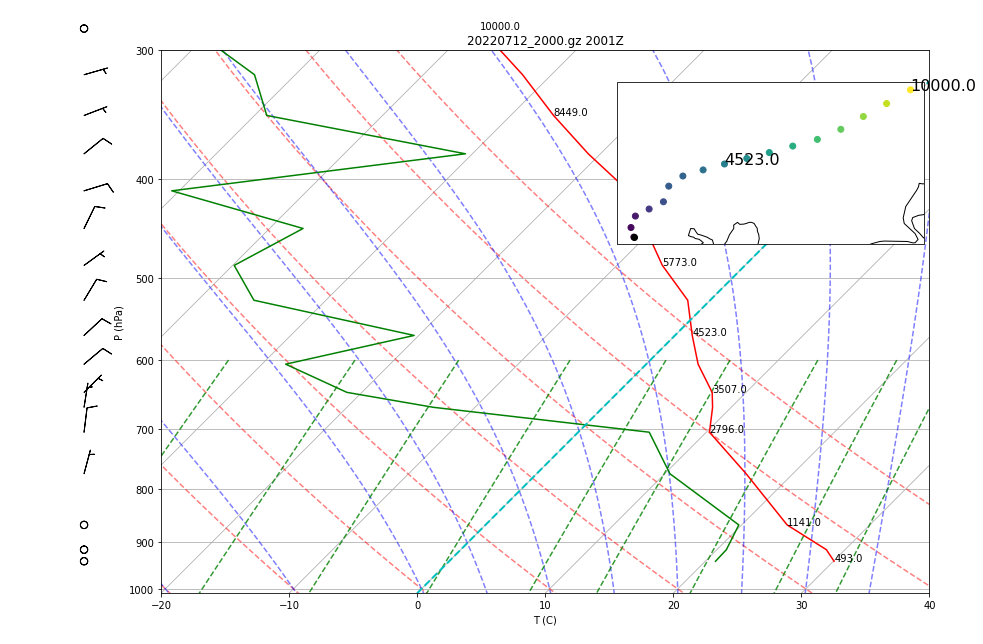

In [9]:
i=0
midway = []
for this_amdar in firstset:
    if this_amdar['airport'] == 'HOU':
        this_amdar['dset_file'] = datasets[-1]
        midway.append(this_amdar)
        i+=1
        print('Winner', i)

n = 0
metpy.plots.SkewT
fig=plt.figure(figsize=[20, 10])

skew = plots.SkewT(fig, rotation=45)
p = midway[n]['p']
p = p * units.hPa
T = midway[n]['T']  # pymeteo.thermo.T( midway[n]['th'], midway[n]['p'])
T = T-273.15
T = T * units.degC
Td = pymeteo.thermo.Td( midway[n]['p'], midway[n]['qv'])
Td = Td-273.15
Td = Td * units.degC
u =  midway[n]['u']
v =  midway[n]['v']
print(p.shape)
print(T.shape)
print(Td.shape)
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

skew.plot(p/100.0, T, 'r')
skew.plot(p/100.0, Td, 'g')
skew.plot_barbs(p/100.0, u, v, xloc=-0.1)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
prof = mpcalc.parcel_profile(p, T[0], Td[0])
skew.plot(p, prof, 'k', linewidth=2)

skew.shade_cape(p, T, parcel_prof)
skew.shade_cin(p, T, parcel_prof, Td)
plt.xlabel('T (C)')
plt.ylabel('P (hPa)')
plt.title(midway[n]['dset_file'] + ' ' + midway[n]['time'])

decimate = 2

for pp, tt, hh in zip(p[::decimate], T[::decimate], midway[n]['z'][::decimate]):
    skew.ax.text(tt, pp/100.0, hh)

plt.ylim([1010,300])
plt.xlim([-20.,40.])

axins = inset_axes(plt.gca(), width="40%", height="40%", loc="upper right", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
mp = axins.scatter(midway[n]['lon'], midway[n]['lat'], c=midway[n]['z'])
axins.add_feature(cartopy.feature.LAKES, zorder=0)
axins.add_feature(cartopy.feature.STATES)
plt.plot(midway[n]['lon'][0], midway[n]['lat'][0], 'ko')
half = int(len(midway[n]['lon'])/2.)

plt.text(midway[n]['lon'][-1], midway[n]['lat'][-1], str(midway[n]['z'][-1]), fontsize=16)
plt.text(midway[n]['lon'][half], midway[n]['lat'][half], str(midway[n]['z'][half]), fontsize=16)


In [10]:
print(p.shape)
print(T[0].shape)
print(Td.shape)

(17,)
()
(17,)


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import act
from datetime import datetime
import metpy.calc as mpcalc
#from metpy.io import get_upper_air_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
#from tabulate import tabulate
import numpy as np
from PIL import Image
import matplotlib.patches as patches
from matplotlib.axis import Axis
from matplotlib.patches import ConnectionPatch

In [12]:
ds = act.io.read_netcdf("housondewnpnM1.b1.20220622.173100.cdf")
ds.keys()
print(ds)

p = ds['pres'].values * units.hPa
T = ds['tdry'].values * units.degC
Td = ds['dp'].values * units.degC
print(p.shape)
print(T.shape)
print(Td.shape)
wind_speed = ds['wspd'].values * units.knots
wind_dir = ds['deg'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

<xarray.Dataset>
Dimensions:      (time: 5736)
Coordinates:
  * time         (time) datetime64[ns] 2022-06-22T17:31:00 ... 2022-06-22T19:...
Data variables: (12/24)
    base_time    datetime64[ns] 2022-06-22
    time_offset  (time) datetime64[ns] 2022-06-22T17:31:00 ... 2022-06-22T19:...
    pres         (time) float32 dask.array<chunksize=(5736,), meta=np.ndarray>
    qc_pres      (time) int32 dask.array<chunksize=(5736,), meta=np.ndarray>
    tdry         (time) float32 dask.array<chunksize=(5736,), meta=np.ndarray>
    qc_tdry      (time) int32 dask.array<chunksize=(5736,), meta=np.ndarray>
    ...           ...
    wstat        (time) float32 dask.array<chunksize=(5736,), meta=np.ndarray>
    asc          (time) float32 dask.array<chunksize=(5736,), meta=np.ndarray>
    qc_asc       (time) int32 dask.array<chunksize=(5736,), meta=np.ndarray>
    lat          (time) float32 dask.array<chunksize=(5736,), meta=np.ndarray>
    lon          (time) float32 dask.array<chunksize=(5736,), m

In [13]:
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

942.6317813411628 hectopascal 24.30515845167878 degree_Celsius


C:\Users\Owner\mattconda\envs\tracer-plotting-dev\lib\site-packages\metpy\calc\thermo.py:951: UserWarning: Duplicate pressure(s) [13.630000114440918] hPa provided. Output profile includes duplicate temperatures as a result.
  warnings.warn(f'Duplicate pressure(s) {unique[counts > 1]:~P} provided. '


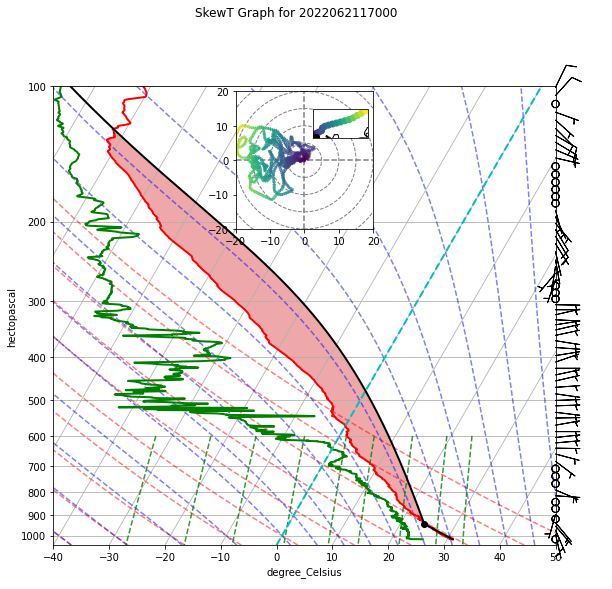

In [14]:
fig = plt.figure(figsize=(9, 9))
fig.suptitle('SkewT Graph for 2022062117000')
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
mask = p>= 100 * units.hPa
skew.plot_barbs(p[mask][::50], u[mask][::50], v[mask][::50])
#shaded regions
skew.shade_cape(p, T, parcel_prof)
skew.shade_cin(p, T, parcel_prof, Td)
#Lines
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
#solid balck line
skew.plot(p, prof, 'k', linewidth=2)
#Red hashed lines
skew.plot_dry_adiabats()
#Blue hashed lines
skew.plot_moist_adiabats()
#Green hashed lines
skew.plot_mixing_lines()
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=-2)
h = Hodograph(ax_hod, component_range=20.)
h.add_grid(increment=5)
h.plot_colormapped(u, v, wind_speed)  

axins = inset_axes(plt.gca(), width="40%", height="40%", loc="upper right", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
mp = axins.scatter(midway[n]['lon'], midway[n]['lat'], c=midway[n]['z'])
axins.add_feature(cartopy.feature.LAKES, zorder=0)
axins.add_feature(cartopy.feature.STATES)
plt.plot(midway[n]['lon'][0], midway[n]['lat'][0], 'ko')
half = int(len(midway[n]['lon'])/2.)
plt.show()

In [15]:
print(T.shape)
print(p.shape)
print(Td.shape)

(5736,)
(5736,)
(5736,)


In [16]:
print(T)

[31.0 30.540000915527344 30.530000686645508 ... -47.0099983215332 -47.0099983215332 -47.0099983215332] degree_Celsius
